<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A1%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_OpenCV_%D0%B8_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семантическая сегментация с помощью OpenCV и глубокого обучения

# Semantic segmentation with OpenCV and deep learning

В этом руководстве вы узнаете, как выполнять семантическую сегментацию с использованием OpenCV, глубокого обучения и сети ENet. 

In this tutorial, you will learn how to perform semantic segmentation using OpenCV, deep learning, and the ENet.




Семантическая сегментация:

Semantic segmentation:

* Разделяет изображение на значимые части. Divides the image into meaningful parts
* Связывает каждый пиксель во входном изображении с меткой класса (например, человек, дорога, машина, автобус и т. Д.). Associates every pixel in the input image with a class label (e.g. person, road, car, bus, etc.)

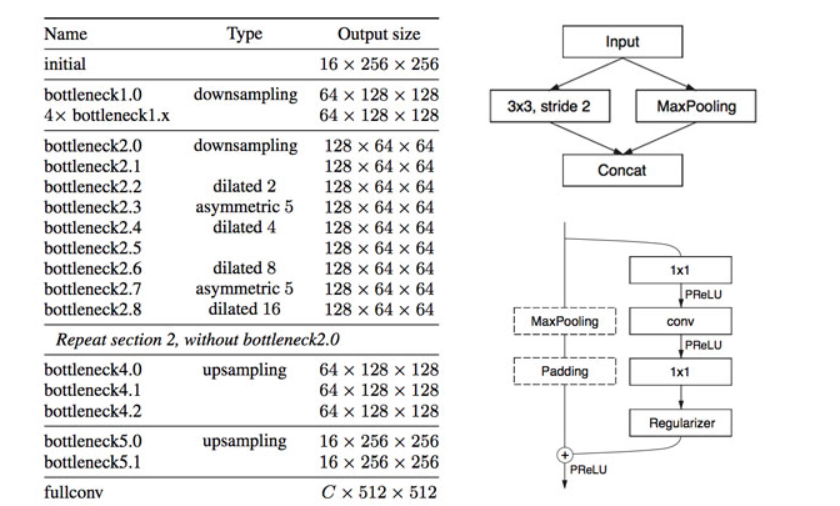

Рисунок 1. Архитектура сети ENet для семантической сегментации. 

Figure 1. ENet network architecture for semantic segmentation.

Основное преимущество ENet заключается в том, что она работает до 18 раз быстрее и требует в 79 раз меньше параметров с аналогичной или лучшей точностью, чем более крупные модели. Размер самой модели всего 3,2 МБ.

The main advantage of ENet is that it is up to 18 times faster and requires 79 times fewer parameters with the same or better accuracy than larger models. The size of the model itself is only 3.2 MB.

Конкретная модель, которую мы используем, обучилась* на 20 классах, в том числе:


The specific model we are using was trained * in 20 classes, including:

* Без метки (т. Е. Фон). No label (i.e. background)
* Дорога. Road
* Тротуар. Sidewalk
* Здания. Building
* Стена. Wall
* Изгородь. Hedge
* Столб. Pillar
* Светофор. Traffic light
* Дорожный знак. Road sign
* Растения. Plants
* Местность. Terrain
* Небо. Sky
* Человек. Human
* Водитель. Driver
* Машина. Car
* Грузовик. Truck
* Автобус. Bus
* Поезд. Train
* Мотоцикл. Motorcycle
* Велосипед. Bicycle





### Загрузка файлов
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_28.semantic_segmentation.zip
!unzip -qq Lesson_28.semantic_segmentation.zip
%cd /content/Lesson_28.semantic_segmentation/

--2022-02-20 09:14:59--  http://dataudt.ru/datasets/cv/Lesson_28.semantic_segmentation.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31490509 (30M) [application/zip]
Saving to: ‘Lesson_28.semantic_segmentation.zip’

Lesson_28.semantic_ 100%[===================>]  30.03M  13.5MB/s    in 2.2s    

2022-02-20 09:15:02 (13.5 MB/s) - ‘Lesson_28.semantic_segmentation.zip’ saved [31490509/31490509]

/content/Lesson_28.semantic_segmentation


### Импорт библиотек
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import imutils
import time
import cv2

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(15,15))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Семантическая сегментация изображений с помощью OpenCV
### Semantic segmentation in images with OpenCV

In [18]:
# явно укажем аргументы необходимые для работы
# model - путь к модели сегментации глубокого обучения
# classes - путь к файлу .txt, содержащему метки классов
# image - путь к входному изображению
# colors - путь к .txt файлу, содержащему цвета для меток
# width - желаемая ширина (в пикселях) входного изображения
# image - путь к изображению 

# explicitly specify the arguments needed to work
# model - path to deep learning segmentation model
# classes - path to .txt file containing class labels
# image - path to input image
# colors - path to .txt file containing colors for labels
# width - desired width (in pixels) of input image

args = {
    "model": "enet-cityscapes/enet-model.net",
    "classes": "enet-cityscapes/enet-classes.txt",
    "image": "images/2.png",
    "colors": "enet-cityscapes/enet-colors.txt",
    "width": 500
}

In [19]:
# загружаем названия меток классов
# load the class label names
CLASSES = open(args["classes"]).read().strip().split("\n")

# если есть файл с цветами, загружаем его с диска
# if a colors file was supplied, load it from disk
if args["colors"]:
	COLORS = open(args["colors"]).read().strip().split("\n")
	COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
	COLORS = np.array(COLORS, dtype="uint8")

# в противном случае нам нужно случайным образом сгенерировать цвета RGB для каждой метки класса
# otherwise, we need to randomly generate RGB colors for each class
# label
else:
    # инициализируем список цветов для представления каждой метки класса в
	# маске (начиная с 'black' для фона / без метки
	# initialize a list of colors to represent each class label in
	# the mask (starting with 'black' for the background/unlabeled
	# regions)
	np.random.seed(42)
	COLORS = np.random.randint(0, 255, size=(len(CLASSES) - 1, 3),
		dtype="uint8")
	COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")

In [20]:
# инициализируем визуализацию легенды
# initialize the legend visualization
legend = np.zeros(((len(CLASSES) * 25) + 25, 300, 3), dtype="uint8")

# перебираем имена классов + цветов
# loop over the class names + colors
for (i, (className, color)) in enumerate(zip(CLASSES, COLORS)):
    # рисуем название класса + цвет на легенде
	# draw the class name + color on the legend
	color = [int(c) for c in color]
	cv2.putText(legend, className, (5, (i * 25) + 17),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
	cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25),
		tuple(color), -1)

In [21]:
# загружаем нашу сохраненную модель с диска
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNet(args["model"])

# загружаем входное изображение, изменяем его размер и делаем из него заготовку,
# помните, что исходные размеры входного изображения ENet были обучены на 1024x512
# load the input image, resize it, and construct a blob from it,
# but keeping mind mind that the original input image dimensions
# ENet was trained on was 1024x512
image = cv2.imread(args["image"])
image = imutils.resize(image, width=args["width"])
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (1024, 512), 0,
	swapRB=True, crop=False)

# пропускаем заготовку через модель сегментации
# perform a forward pass using the segmentation model
net.setInput(blob)
start = time.time()
output = net.forward()
end = time.time()

# показываем количество времени, которое потребовалось для вывода
# show the amount of time inference took
print("[INFO] inference took {:.4f} seconds".format(end - start))

[INFO] loading model...
[INFO] inference took 0.7362 seconds


In [22]:
# выводим общее количество классов вместе с размерностью
# маски в виде выходного массива
# infer the total number of classes along with the spatial dimensions
# of the mask image via the shape of the output array
(numClasses, height, width) = output.shape[1:4]

# наша карта идентификаторов выходных классов будет иметь вид номер класса x высота x ширина,
# поэтому мы берем максимальный аргумент, чтобы найти метку класса с
# наибольшей вероятностью для каждой (x, y)-координаты в изображение
# our output class ID map will be num_classes x height x width in
# size, so we take the argmax to find the class label with the
# largest probability for each and every (x, y)-coordinate in the
# image
classMap = np.argmax(output[0], axis=0)

# учитывая карту идентификаторов классов, мы можем сопоставить каждый из идентификаторов с его
# соответствующим цветом
# given the class ID map, we can map each of the class IDs to its
# corresponding color
mask = COLORS[classMap]

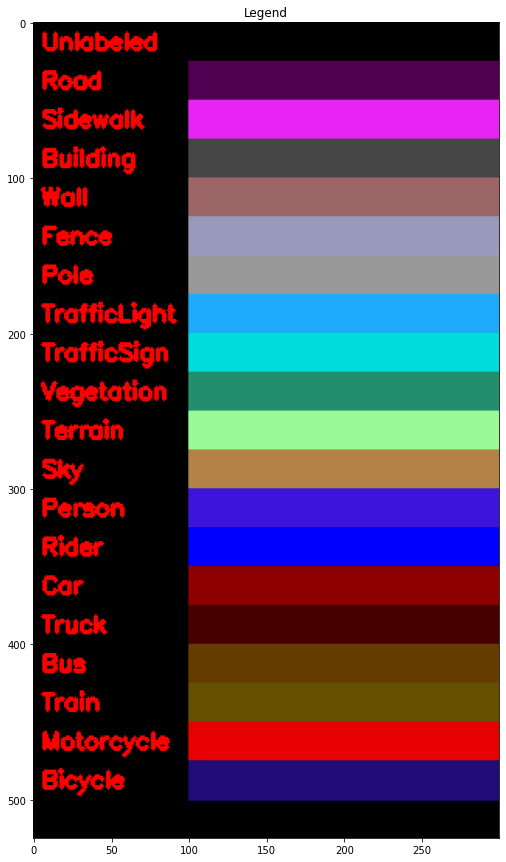

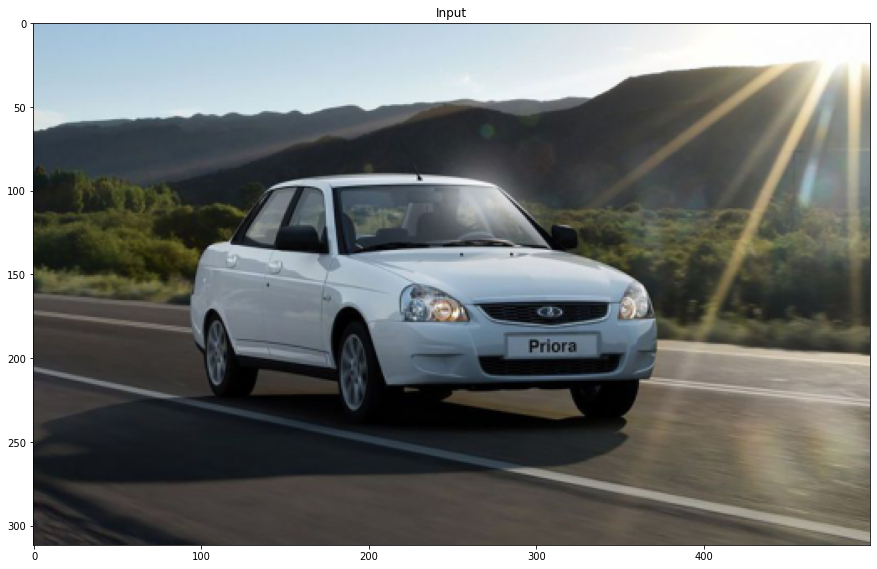

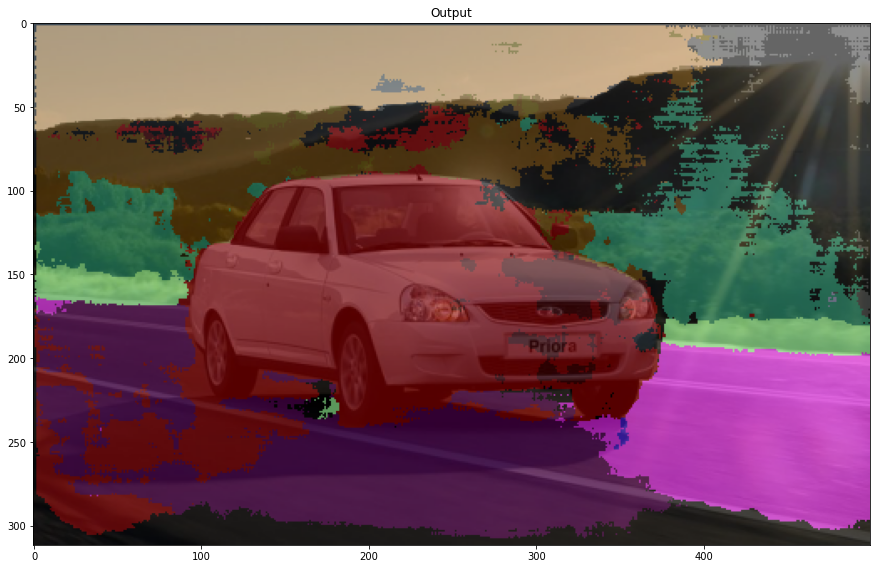

In [23]:
# изменяем размер маски так, чтобы ее размеры соответствовали исходному размеру
# входного кадра (мы не используем карту классов
# здесь для чего угодно, но вот так бы мы изменили его размер
# для извлечения определенных пиксели / классы)
# resize the mask and class map such that its dimensions match the
# original size of the input image (we're not using the class map
# here for anything else but this is how you would resize it just in
# case you wanted to extract specific pixels/classes)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]),
	interpolation=cv2.INTER_NEAREST)
classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]),
	interpolation=cv2.INTER_NEAREST)

# выполняем взвешенную комбинацию входного кадра с маской
# чтобы сформировать визуализацию вывода
# perform a weighted combination of the input image with the mask to
# form an output visualization
output = ((0.4 * image) + (0.6 * mask)).astype("uint8")

# показать входное и выходное изображения
# show the input and output images
plt_imshow("Legend", legend)
plt_imshow("Input", image)
plt_imshow("Output", output)

### Реализация семантической сегментации видео с OpenCV

### Implementing semantic segmentation in video with OpenCV

In [24]:
# явно укажем аргументы необходимые для работы
# model - путь к модели сегментации глубокого обучения
# classes - путь к .txt файлу, содержащему метки классов
# colors - путь к .txt файлу, содержащему цвета для меток
# video - путь к входному видеофайлу
# output - путь к выходному видеофайлу
# show - показывать или нет кадр на экране
# width - желаемая ширина (в пикселях) входного изображения

# explicitly specify the arguments needed to work
# model - path to deep learning segmentation model
# classes - path to .txt file containing class labels
# colors - path to .txt file containing colors for labels
# video - path to input video file
# output - path to output video file
# show - whether or not to display frame to screen
# width - desired width (in pixels) of input image
args = {
    "model": "enet-cityscapes/enet-model.net",
    "classes": "enet-cityscapes/enet-classes.txt",
    "colors": "enet-cityscapes/enet-colors.txt",
    "video": "videos/video.mp4",
    "output": "output/output.avi",
    "show": 1,
    "width": 500
}

In [25]:
# загружаем названия меток классов
# load the class label names
CLASSES = open(args["classes"]).read().strip().split("\n")

# если есть файл с цветами, загружаем его с диска
# if a colors file was supplied, load it from disk
if args["colors"]:
	COLORS = open(args["colors"]).read().strip().split("\n")
	COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
	COLORS = np.array(COLORS, dtype="uint8")

# в противном случае нам нужно случайным образом сгенерировать цвета RGB для каждой метки класса
# otherwise, we need to randomly generate RGB colors for each class
# label
else:
    # инициализируем список цветов для представления каждой метки класса в
	# маске (начиная с 'black' для фона / без метки
	# initialize a list of colors to represent each class label in
	# the mask (starting with 'black' for the background/unlabeled
	# regions)
	np.random.seed(42)
	COLORS = np.random.randint(0, 255, size=(len(CLASSES) - 1, 3),
		dtype="uint8")
	COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")

In [26]:
# загружаем нашу сохраненную модель с диска
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNet(args["model"])

# инициализируем видео и указатель для вывода видеофайла
# initialize the video stream and pointer to output video file
vs = cv2.VideoCapture(args["video"])
writer = None

# пытаемся определить общее количество кадров в видео
# try to determine the total number of frames in the video file
try:
	prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# произошла ошибка при попытке определить общее
# количество кадров в видео
# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	total = -1

[INFO] loading model...
[INFO] 240 total frames in video


In [27]:
# перебираем кадры из видео
# loop over frames from the video file stream
while True:
    # читаем следующий кадр из файла
	# read the next frame from the file
	(grabbed, frame) = vs.read()

    # если кадр не был захвачен, значит мы дошли до конца видео
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

    # создаем шаблон из кадра и пропускаем его через
	# модель сегментации
	# construct a blob from the frame and perform a forward pass
	# using the segmentation model
	frame = imutils.resize(frame, width=args["width"])
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (1024, 512), 0,
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	output = net.forward()
	end = time.time()
 
    # выводим общее количество классов вместе с размерностью
	# маски в виде выходного массива
    # infer the total number of classes along with the spatial
	# dimensions of the mask image via the shape of the output array
	(numClasses, height, width) = output.shape[1:4]

    # наша карта идентификаторов выходных классов будет иметь вид номер класса x высота x ширина,
	# поэтому мы берем максимальный аргумент, чтобы найти метку класса с
	# наибольшей вероятностью для каждой (x, y)-координаты в изображение
	# our output class ID map will be num_classes x height x width in
	# size, so we take the argmax to find the class label with the
	# largest probability for each and every (x, y)-coordinate in the
	# image
	classMap = np.argmax(output[0], axis=0)

    # учитывая карту идентификаторов классов, мы можем сопоставить каждый из идентификаторов с его
	# соответствующим цветом
	# given the class ID map, we can map each of the class IDs to its
	# corresponding color
	mask = COLORS[classMap]

    # изменяем размер маски так, чтобы ее размеры соответствовали исходному размеру
	# входного кадра
	# resize the mask such that its dimensions match the original size
	# of the input frame
	mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]),
		interpolation=cv2.INTER_NEAREST)

    # выполняем взвешенную комбинацию входного кадра с маской
	# чтобы сформировать визуализацию вывода
	# perform a weighted combination of the input frame with the mask
	# to form an output visualization
	output = ((0.3 * frame) + (0.7 * mask)).astype("uint8")
 
    # проверяем, есть ли видео
    # check if the video writer is None
	if writer is None:
        # инициализируем наше видео
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(output.shape[1], output.shape[0]), True)

        # немного информации по обработке кадра
		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time: {:.4f}".format(
				elap * total))

    # записываем выходной кадр на диск
	# write the output frame to disk
	writer.write(output)

# очищаем данные
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] single frame took 0.5507 seconds
[INFO] estimated total time: 132.1739
[INFO] cleaning up...


Выполнение ячейки может занять некоторое время. Наше выходное видео создается в формате .avi. Нам нужно преобразовать его в формат .mp4.

Note that the above code block may take time to execute. If you are interested to view the video within Colab just execute the following code blocks. Note that it may be time-consuming.

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format.

In [28]:
!ffmpeg -i output/output.avi output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [30]:
#@title Воспроизводим выходное видео

#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)